# Detection of gH2AX spots

---

## 0. Environmental setup

In [1]:
import skimage
import numpy as np
import sys
import tifffile
from skimage import filters
from skimage import morphology
from skimage import measure
from scipy import ndimage as ndi
from skimage.segmentation import watershed, find_boundaries, mark_boundaries
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.exposure import adjust_gamma, equalize_hist, rescale_intensity
import cv2

sys.path.append("../..")

from src.utils.basic.io import get_file_list
import matplotlib.pyplot as plt

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [199]:
img_locs = get_file_list(
    "../../data/control/proteins/HV6_ctrl_PBMC_Dapi_gH2AX__lamin_12_8_21_2X_16bit_poly/preprocessed/full_pipeline/segmentation/nuclei_images"
)
imgs = []
for loc in img_locs:
    imgs.append(tifffile.imread(loc))

<IPython.core.display.Javascript object>

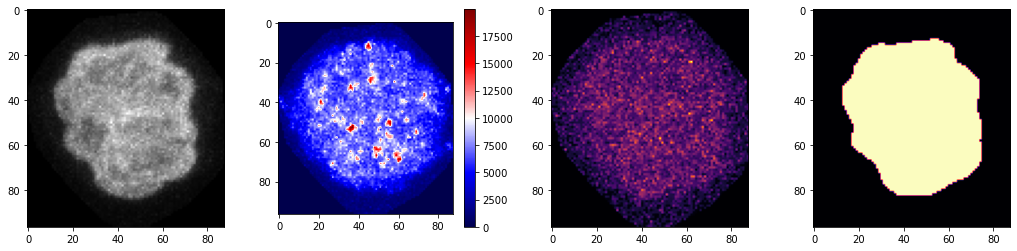

<IPython.core.display.Javascript object>

In [200]:
img_id = 0

fig, ax = plt.subplots(ncols=4, figsize=[18, 4])
ax = ax.flatten()
ax[0].imshow(imgs[img_id][:, 0, :, :].max(axis=0), cmap="gray")
p = ax[1].imshow(imgs[img_id][:, 1, :, :].max(axis=0), cmap="seismic")
fig.colorbar(p, ax=ax[1])
ax[2].imshow(imgs[img_id][:, 2, :, :].max(axis=0), cmap="inferno")
ax[3].imshow(imgs[img_id][:, 3, :, :].max(axis=0), cmap="magma")

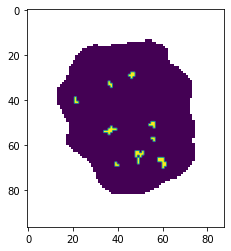

<IPython.core.display.Javascript object>

In [201]:
tmp = np.ma.array(
    imgs[img_id][:, 1].max(axis=0), mask=~(imgs[img_id][:, 3].max(axis=0).astype(bool))
)
plt.imshow(
    morphology.remove_small_objects(tmp > tmp.mean() + tmp.std() * 2.5, min_size=3)
)

In [202]:
gh2ax_imgs = []
masks = []
for img in imgs:
    gh2ax_imgs.append(img[:, 1, :, :])
    masks.append(img[:, -1, :, :])

<IPython.core.display.Javascript object>

In [203]:
min_dist = 1
min_size = 4
alpha = 2.5
sigma = 0.5
scale_ps = (1, 99)
beta = 1.2

<IPython.core.display.Javascript object>

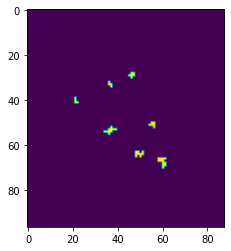

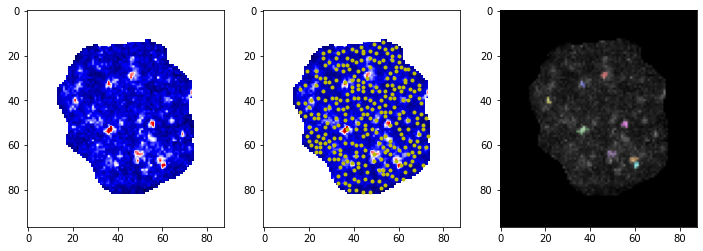

7


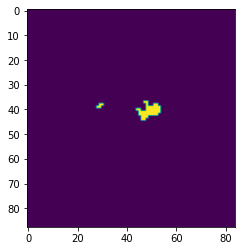

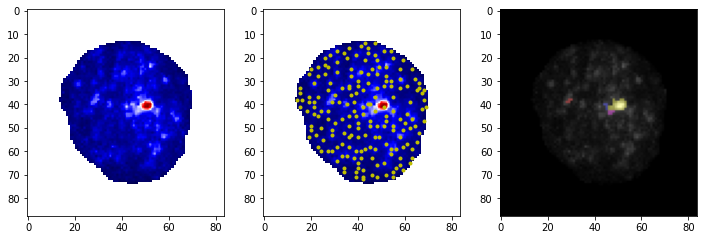

3


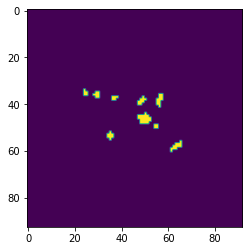

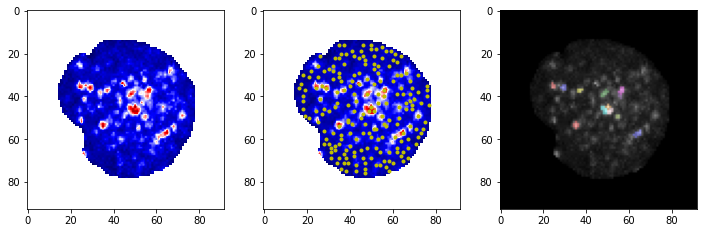

11


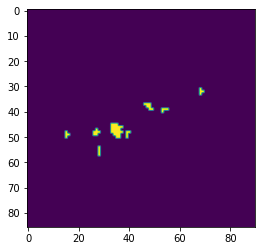

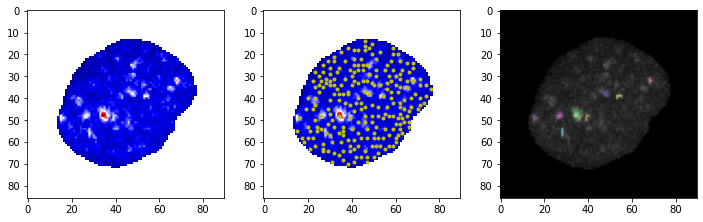

7


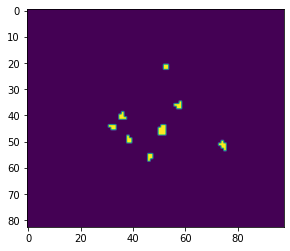

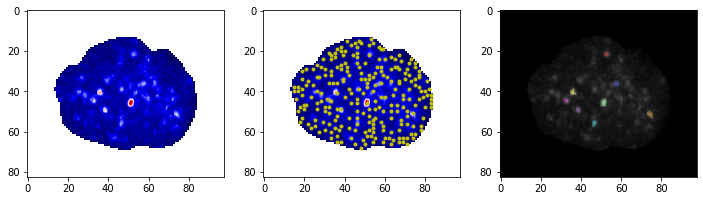

7


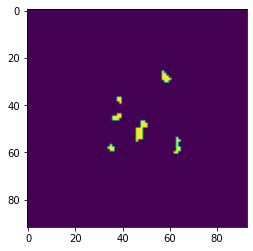

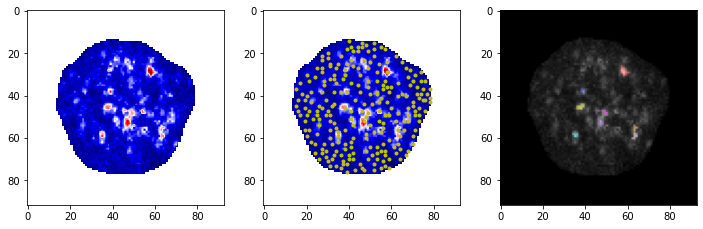

8


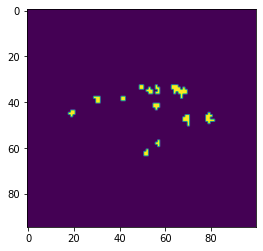

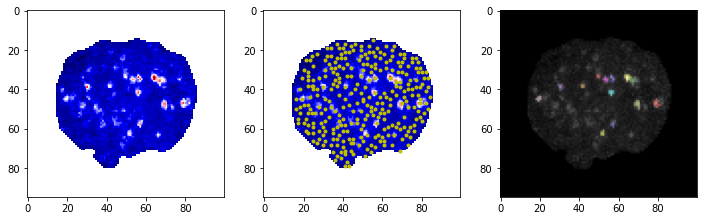

12


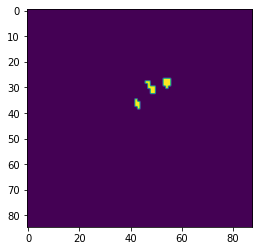

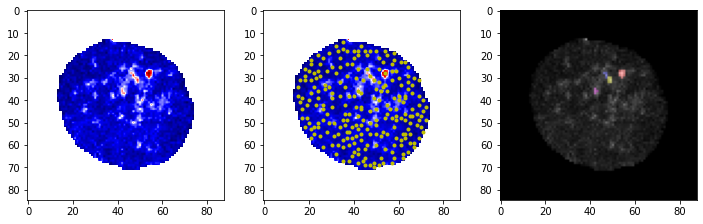

3


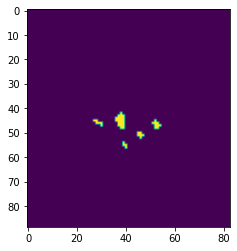

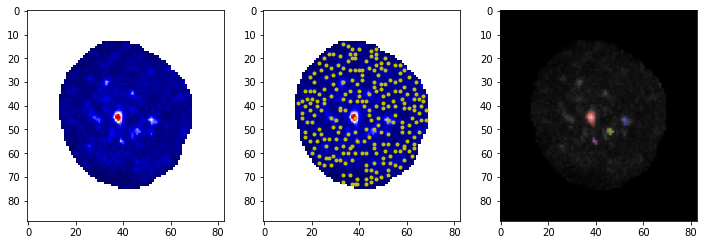

3


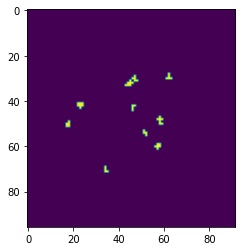

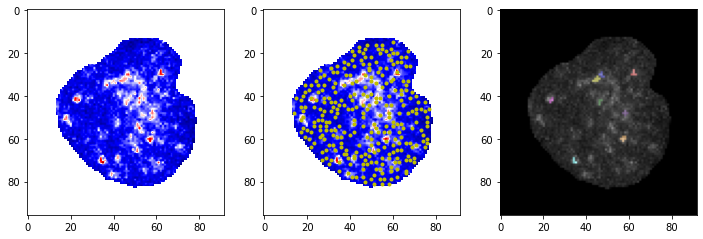

7


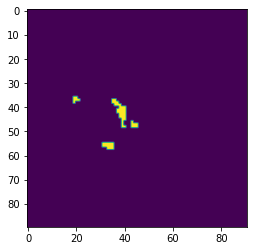

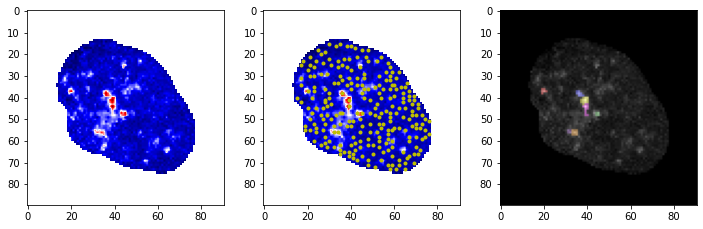

6
Average counts: 6.788018433179723


<IPython.core.display.Javascript object>

In [204]:
n_counts = 0

for i in range(len(gh2ax_imgs)):
    img = gh2ax_imgs[i].max(axis=0)
    nuc_mask = masks[i].max(axis=0).astype(bool)

    # pmin, pmax = np.percentile(img, scale_ps)
    # img = rescale_intensity(img, in_range=(pmin, pmax))
    #     img = img * beta
    filtered = filters.gaussian(img, sigma)
    # filtered = filters.median(img)
    filtered = img.copy()
    img = np.ma.array(img, mask=~nuc_mask)
    filtered = np.ma.array(filtered, mask=~nuc_mask)

    img = np.clip((img - img.min()) / (img.max() - img.min()) * 255, 0, 255).astype(
        np.uint8
    )
    filtered = np.clip(
        (filtered - filtered.min()) / (filtered.max() - filtered.min()) * 255, 0, 255
    ).astype(np.uint8)
    # filtered = morphology.white_tophat(filtered, morphology.disk(20))
    # filtered = np.ma.filled(filtered, fill_value=0)

    threshold = filtered.mean() + alpha * filtered.std()
    # threshold = filtered.min() + 0.7 * (filtered.max() - filtered.min())
    foci_mask = filtered > threshold
    foci_mask = np.ma.filled(foci_mask, fill_value=False)
    # foci_mask = morphology.binary_opening(foci_mask)
    foci_mask = morphology.remove_small_objects(foci_mask, min_size=min_size)

    distance = ndi.distance_transform_edt(foci_mask)
    coords = peak_local_max(filtered, min_distance=min_dist)
    peak_mask = np.zeros(filtered.shape, dtype=bool)
    peak_mask[tuple(coords.T)] = True
    markers, _ = ndi.label(peak_mask)
    labels = watershed(-filtered, markers, mask=foci_mask)
    labels = morphology.remove_small_objects(labels, min_size=min_size)

    n_counts += len(np.unique(labels)) - 2
    labels = np.ma.array(labels, mask=~(masks[i].max(axis=0).astype(bool)))

    if i % 20 == 0:
        plt.imshow(foci_mask)
        plt.show()
        fig, ax = plt.subplots(figsize=[12, 4], ncols=3)
        scaled = np.clip(
            (img - img.min()) / (img.max() - img.min()) * 255, 0, 255
        ).astype(np.uint8)
        ax = ax.flatten()
        ax[0].imshow(scaled, vmin=0, vmax=255, cmap="seismic")
        ax[1].imshow(filtered, cmap="seismic", vmin=0, vmax=255)
        ax[1].plot(coords[:, 1], coords[:, 0], "y.", markersize=4, markeredgewidth=2)

        labels = np.ma.filled(labels, fill_value=0)
        scaled = np.ma.filled(scaled, fill_value=0)
        scaled = label2rgb(labels, np.ma.filled(filtered, fill_value=0), bg_label=0)
        ax[2].imshow(scaled)

        plt.show()
        plt.close()
        print(len(np.unique(labels)) - 2)
print("Average counts: {}".format(n_counts / len(gh2ax_imgs)))

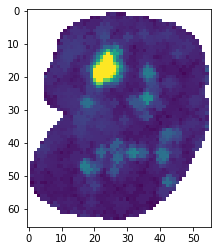

<IPython.core.display.Javascript object>

In [72]:
plt.imshow(filtered - morphology.white_tophat(img, morphology.disk(1)))

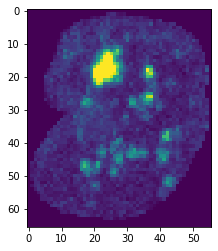

<IPython.core.display.Javascript object>

In [61]:
plt.imshow(filtered)

Text(0.5, 1.0, 'Borders')

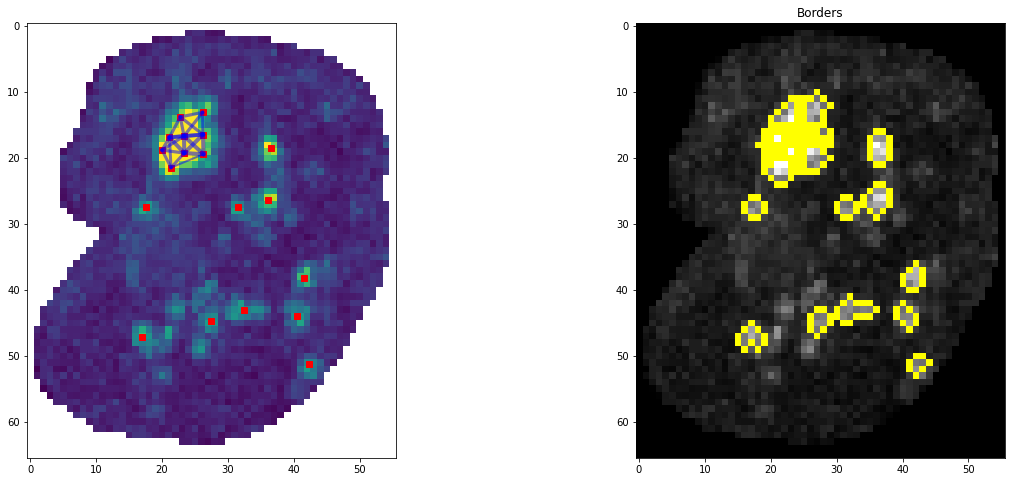

<IPython.core.display.Javascript object>

In [14]:
from skimage.morphology import dilation
from skimage.measure import perimeter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(img)
dist_map = ndi.distance_transform_edt(labels)

node_dict = {}
for c_node in np.unique(labels[labels > 0]):
    y_n, x_n = np.where(labels == c_node)
    node_dict[c_node] = {
        "x": np.mean(x_n),
        "y": np.mean(y_n),
        "width": np.mean(dist_map[labels == c_node]),
        "perimeter": perimeter(labels == c_node),
    }
    ax1.plot(np.mean(x_n), np.mean(y_n), "rs")

edge_dict = {}

for i in node_dict.keys():
    i_grow = dilation(labels == i, np.ones((3, 3)))
    for j in node_dict.keys():
        if i < j:
            j_grow = dilation(labels == j, np.ones((3, 3)))
            interface_length = np.sum(i_grow & j_grow)
            if interface_length > 0:
                v_nodes = [i, j]

                edge_dict[(i, j)] = {
                    "start": v_nodes[0],
                    "start_perimeter": node_dict[v_nodes[0]]["perimeter"],
                    "end_perimeter": node_dict[v_nodes[-1]]["perimeter"],
                    "end": v_nodes[-1],
                    "interface_length": interface_length,
                    "euclidean_distance": np.sqrt(
                        np.square(
                            node_dict[v_nodes[0]]["x"] - node_dict[v_nodes[-1]]["x"]
                        )
                        + np.square(
                            node_dict[v_nodes[0]]["y"] - node_dict[v_nodes[-1]]["y"]
                        )
                    ),
                    "max_width": np.max(dist_map[i_grow & j_grow]),
                    "mean_width": np.mean(dist_map[i_grow & j_grow]),
                }
                s_node = node_dict[v_nodes[0]]
                e_node = node_dict[v_nodes[-1]]
                ax1.plot(
                    [s_node["x"], e_node["x"]],
                    [s_node["y"], e_node["y"]],
                    "b-",
                    linewidth=np.max(dist_map[i_grow & j_grow]),
                    alpha=0.5,
                )

ax2.imshow(mark_boundaries(label_img=labels, image=np.ma.filled(img, fill_value=0)))
ax2.set_title("Borders")

In [15]:
import pandas as pd

edge_df = pd.DataFrame(list(edge_dict.values()))
edge_df.head(5)

,start,start_perimeter,end_perimeter,end,interface_length,euclidean_distance,max_width,mean_width
0,15,10.828427,11.863961,16,12,3.454694,3.162278,1.788570
1,15,10.828427,9.207107,17,6,4.368057,3.162278,2.731508
2,15,10.828427,7.414214,18,8,3.514157,3.162278,1.705123
3,15,10.828427,3.414214,19,7,2.951838,3.162278,2.660731
4,16,11.863961,9.207107,17,9,3.368215,3.162278,1.534729


<IPython.core.display.Javascript object>

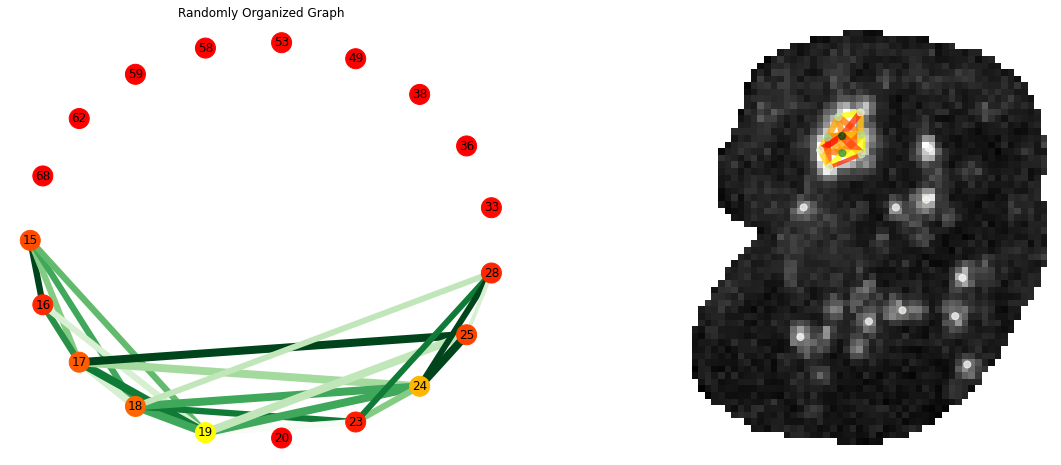

<IPython.core.display.Javascript object>

In [22]:
import networkx as nx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
G = nx.Graph()
for k, v in node_dict.items():
    G.add_node(k, weight=v["width"])
for k, v in edge_dict.items():
    G.add_edge(v["start"], v["end"], **v)
nx.draw_shell(
    G,
    ax=ax1,
    with_labels=True,
    node_color=[node_dict[k]["width"] for k in sorted(node_dict.keys())],
    node_size=400,
    cmap=plt.cm.autumn,
    edge_color=[G.edges[k]["interface_length"] for k in list(G.edges.keys())],
    width=[2 * G.edges[k]["max_width"] for k in list(G.edges.keys())],
    edge_cmap=plt.cm.Greens,
)
ax1.set_title("Randomly Organized Graph")
ax2.imshow(img, cmap="gray")
nx.draw(
    G,
    pos={k: (v["x"], v["y"]) for k, v in node_dict.items()},
    ax=ax2,
    node_color=[node_dict[k]["width"] for k in sorted(node_dict.keys())],
    node_size=50,
    cmap=plt.cm.Greens,
    edge_color=[G.edges[k]["interface_length"] for k in list(G.edges.keys())],
    width=[2 * G.edges[k]["max_width"] for k in list(G.edges.keys())],
    edge_cmap=plt.cm.autumn,
    alpha=0.75,
    with_labels=False,
)

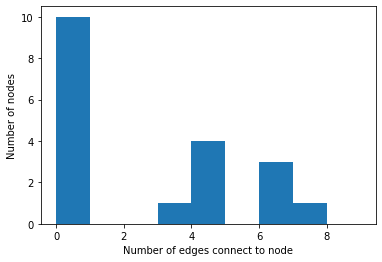

<IPython.core.display.Javascript object>

In [20]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.hist(degree_sequence, bins=np.arange(10)), plt.xlabel(
    "Number of edges connect to node"
), plt.ylabel("Number of nodes")
plt.show()

0


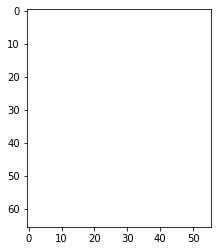

1


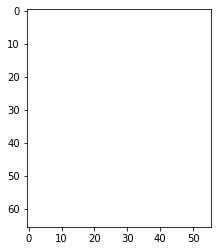

2


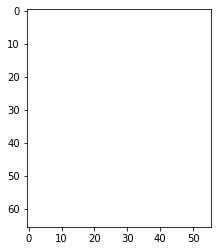

3


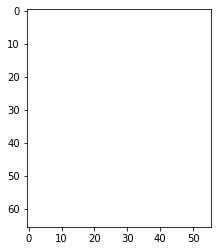

4


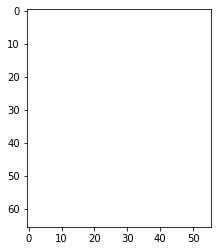

5


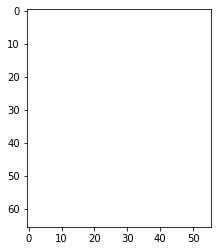

6


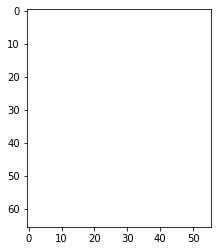

7


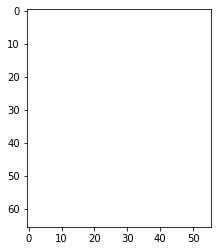

8


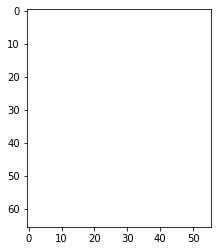

9


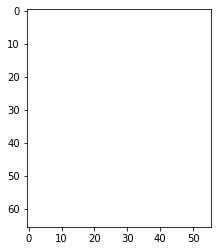

10


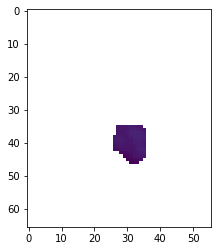

11


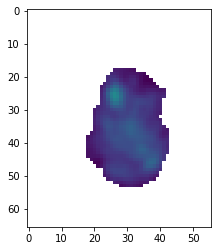

12


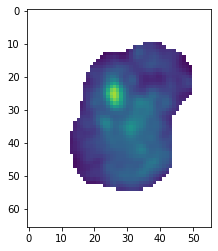

13


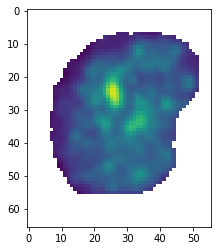

14


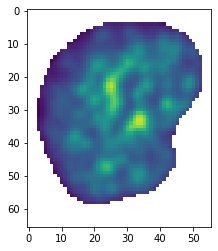

15


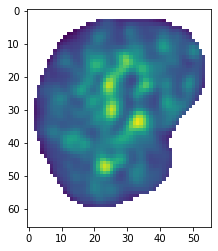

16


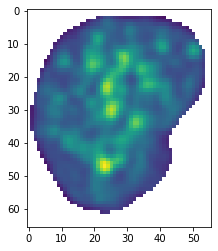

17


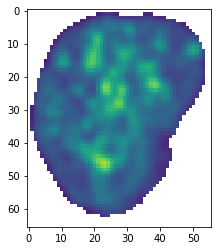

18


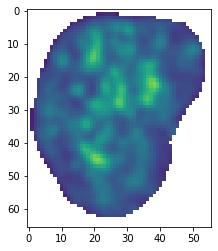

19


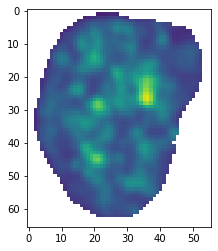

20


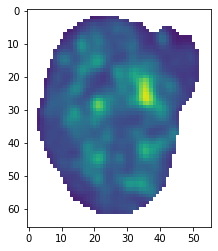

21


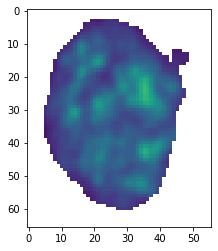

22


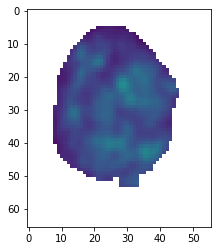

23


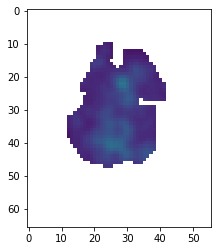

24


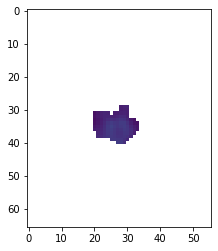

25


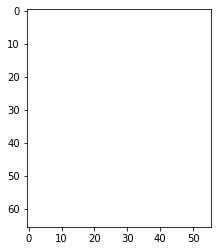

26


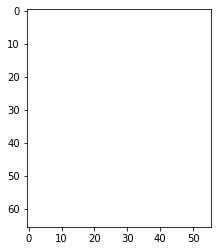

27


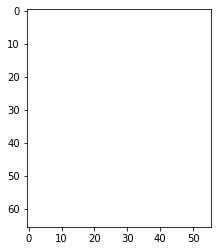

28


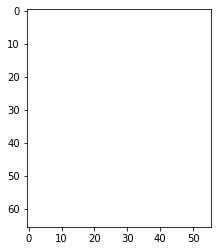

29


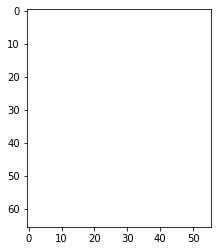

30


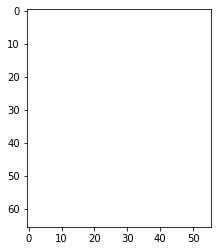

31


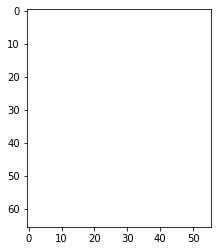

32


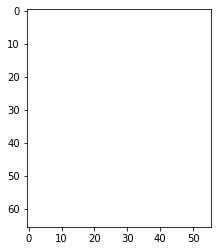

33


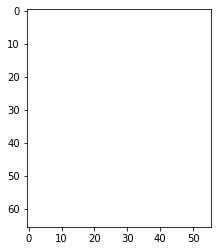

34


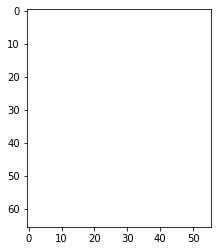

35


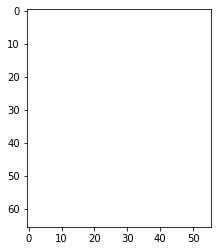

36


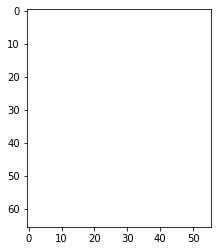

37


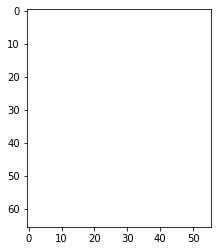

38


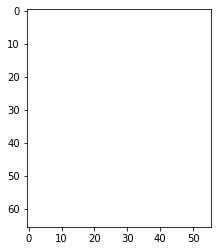

39


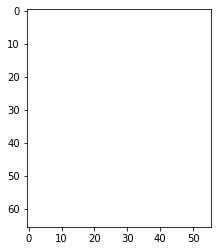

40


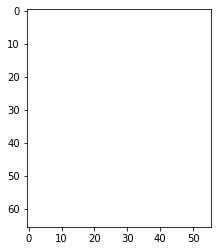

41


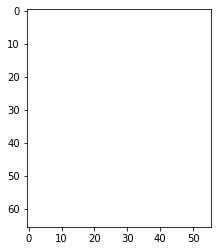

<IPython.core.display.Javascript object>

In [41]:
tmp = gh2ax_imgs[1]
mask = masks[1].astype(bool)
p1, p99 = np.percentile(tmp, (1, 99.9))
tmp = rescale_intensity(tmp, (p1, p99))
tmp = filters.gaussian(tmp, 1)
tmp = np.ma.array(tmp, mask=~mask)
tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
# tmp = np.clip(np.ma.filled(tmp, fill_value=0) * 255, 0, 255).astype(np.uint8)

for i in range(len(tmp)):
    print(i)
    plt.imshow(tmp[i], vmin=0, vmax=1)
    plt.show()
    plt.close()

0


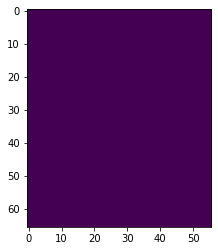

1


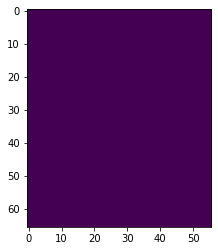

2


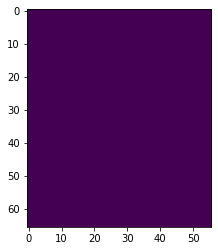

3


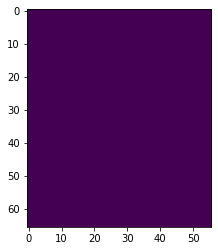

4


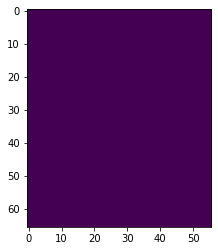

5


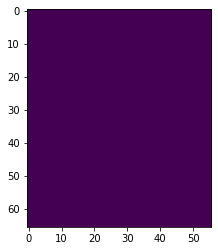

6


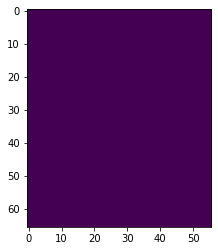

7


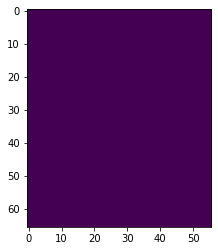

8


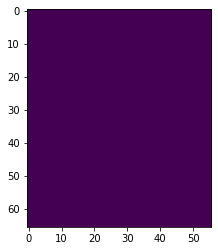

9


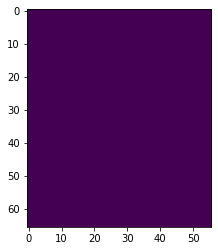

10


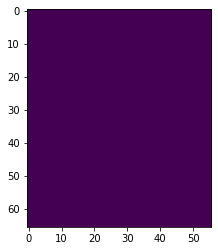

11


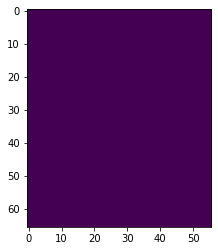

12


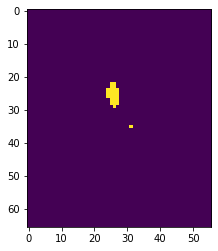

13


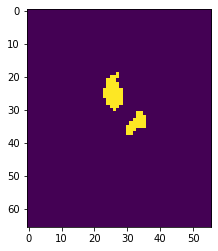

14


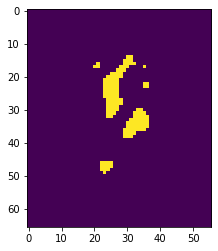

15


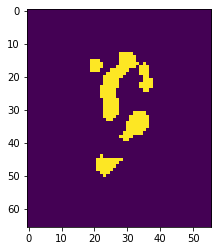

16


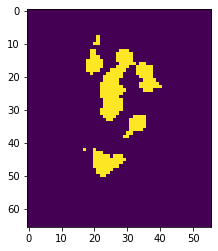

17


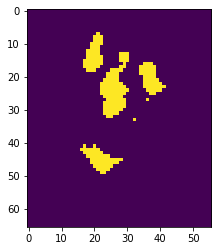

18


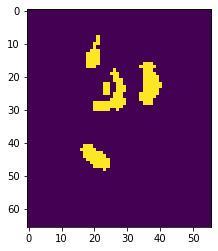

19


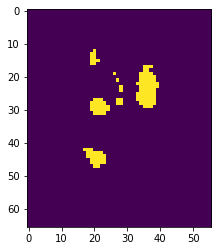

20


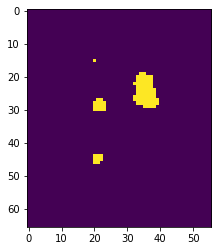

21


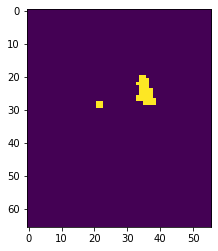

22


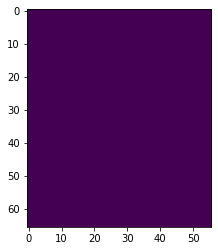

23


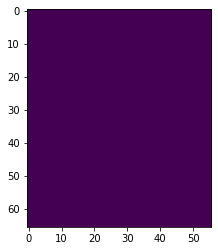

24


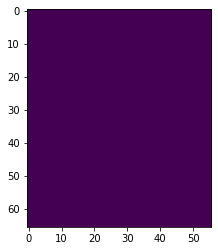

25


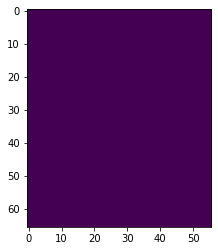

26


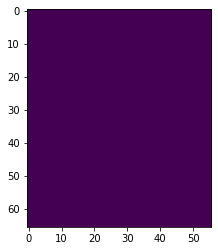

27


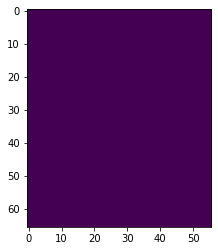

28


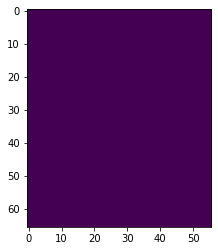

29


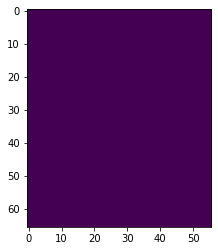

30


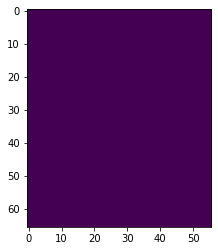

31


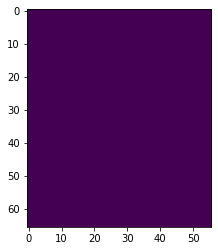

32


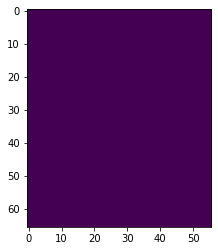

33


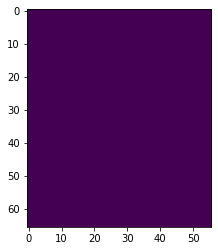

34


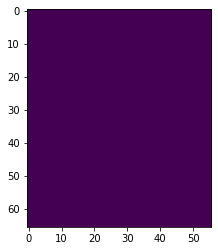

35


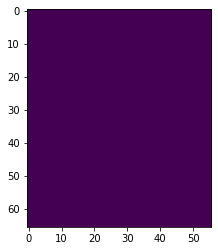

36


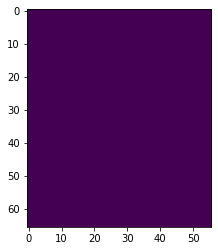

37


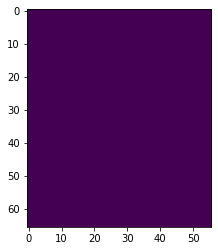

38


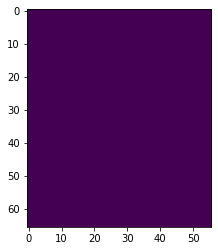

39


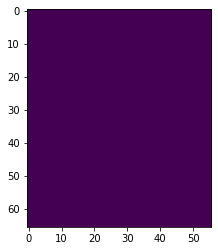

40


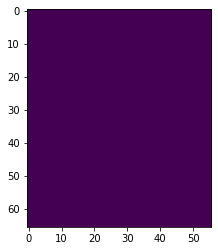

41


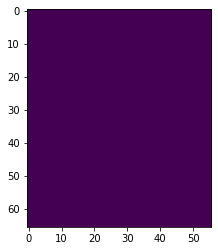

<IPython.core.display.Javascript object>

In [42]:
threshold = tmp.mean() + 1.5 * tmp.std()
foci_mask = tmp > threshold
foci_mask = morphology.binary_opening(foci_mask)
foci_mask = morphology.remove_small_objects(foci_mask, min_size=50)

for i in range(len(foci_mask)):
    print(i)
    plt.imshow(foci_mask[i])
    plt.show()
    plt.close()

In [46]:
tmpp = tmp.copy()
tmpp[~morphology.binary_dilation(foci_mask)] = 0
distance = ndi.distance_transform_edt(tmpp)
coords = peak_local_max(distance, min_distance=min_dist)
peak_mask = np.zeros(foci_mask.shape, dtype=bool)
peak_mask[tuple(coords.T)] = True
markers, _ = ndi.label(peak_mask)
labels = watershed(-tmpp, markers, mask=foci_mask, compactness=0)
labels = morphology.remove_small_objects(labels, min_size=4)

<IPython.core.display.Javascript object>

In [47]:
len(np.unique(labels))

14

<IPython.core.display.Javascript object>

0


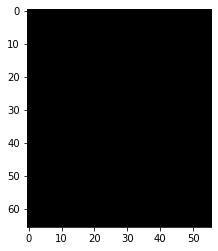

1


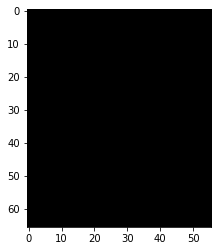

2


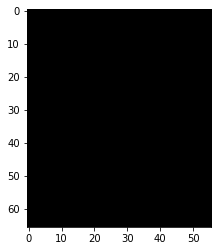

3


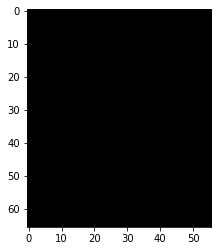

4


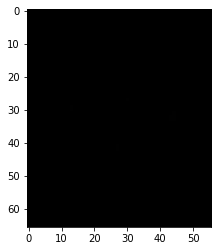

5


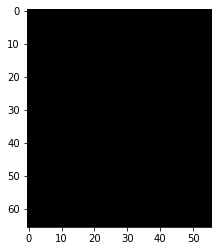

6


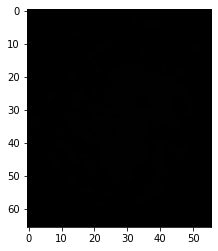

7


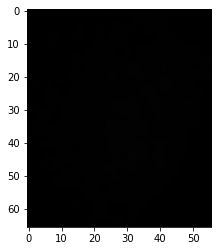

8


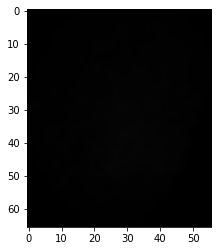

9


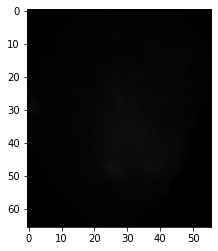

10


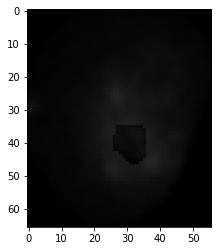

11


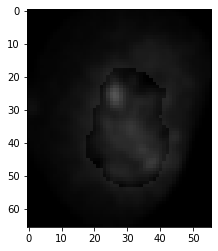

12


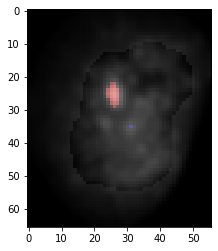

13


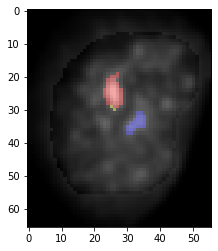

14


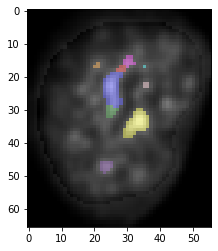

15


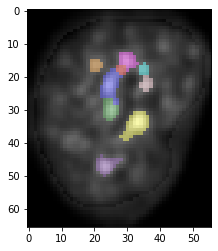

16


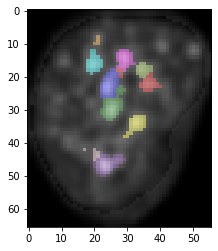

17


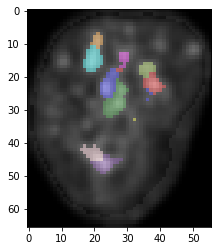

18


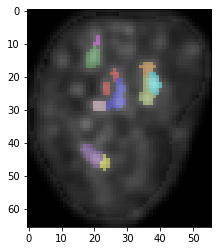

19


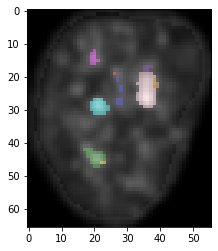

20


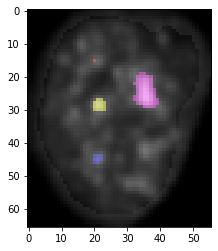

21


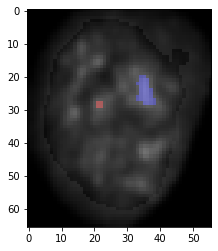

22


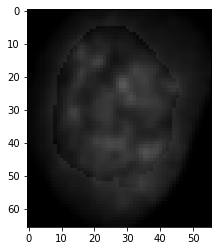

23


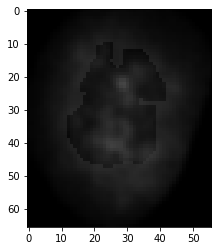

24


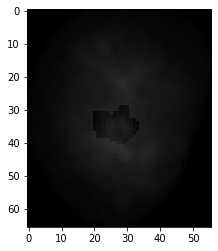

25


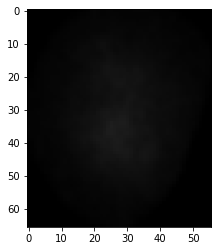

26


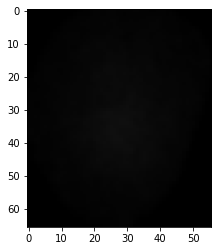

27


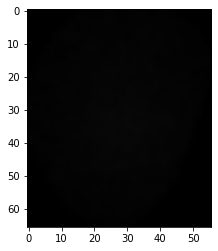

28


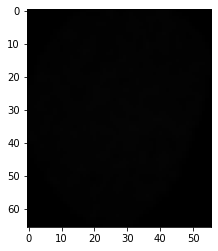

29


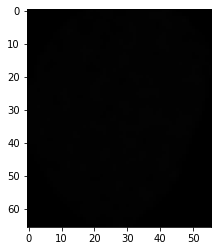

30


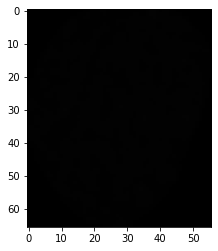

31


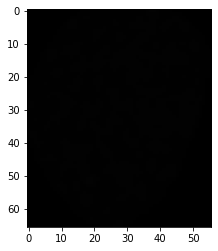

32


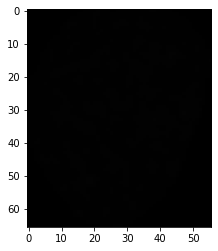

33


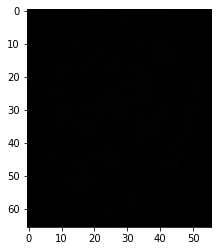

34


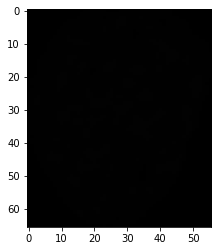

35


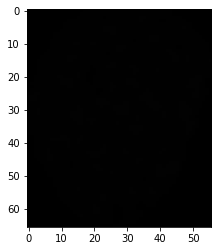

36


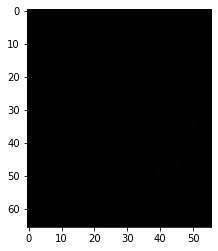

37


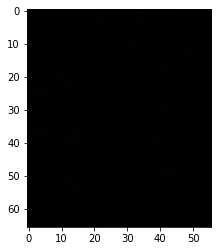

38


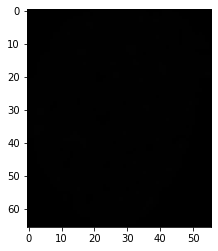

39


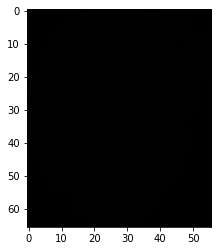

40


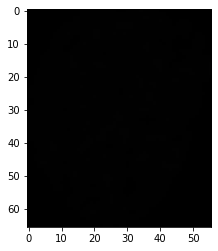

41


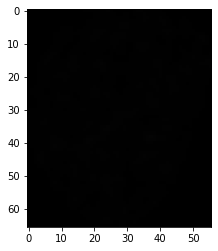

<IPython.core.display.Javascript object>

In [48]:
for i in range(len(foci_mask)):
    print(i)
    plt.imshow(label2rgb(labels[i], tmp[i], bg_label=0), vmin=0, vmax=labels.max())
    plt.show()
    plt.close()